### Figures of spatial variation in continental vs. glacial river contributions 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt
from datetime import date
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import warnings
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
warnings.filterwarnings('ignore')
import glob

%matplotlib inline

In [4]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Parameters:

In [5]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref = '/data/brogalla/run_storage/Mn-set4-202004/'
folder_riv = '/data/brogalla/run_storage/riv-2a-202005/'
folder_con = '/data/brogalla/run_storage/riv-2b-202005/'

# Time series folders:
folder_ts_ref   = '/ocean/brogalla/GEOTRACES/time-series/Mn-set4-202004/'
folder_ts_riv2a = '/ocean/brogalla/GEOTRACES/time-series/riv-2a-202005/'
folder_ts_riv2b = '/ocean/brogalla/GEOTRACES/time-series/riv-2b-202005/'

# Boundary coordinates:
l1i = 2013-imin;                      l1j = np.arange(300-jmin,392-jmin)
l2i = 1935-imin;                      l2j = np.arange(450-jmin,530-jmin)
l3i = np.arange(1850-imin,1885-imin); l3j = 555-jmin
l4i = np.arange(1753-imin,1837-imin); l4j = 568-jmin
l5i = np.arange(1720-imin,1790-imin); l5j = 605-jmin
l6i = 1730-imin;                      l6j = np.arange(660-jmin,690-jmin)
t1i = np.arange(1635-imin,1653-imin); t1j = 760-jmin
r1i = 1520-imin;                      r1j = np.arange(505-jmin,673-jmin)
r2i = 1520-imin;                      r2j = np.arange(385-jmin,405-jmin)
N1i = np.arange(1570-imin,1630-imin); N1j = 635-jmin #Nares
P1i = 1585-imin;                      P1j = np.arange(485-jmin,538-jmin)  #Parry channel
P1j = P1j[10:-5]; N1i = N1i[11:-8]

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(164/N, 1, N)
vals_cont[:, 1] = np.linspace(116/N, 1, N)
vals_cont[:, 2] = np.linspace(84/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(113/N, 1, N)
vals_glac[:, 1] = np.linspace(169/N, 1, N)
vals_glac[:, 2] = np.linspace(144/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

##### Load files:

In [6]:
# Meshmasks
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])

In [7]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

##### Functions:

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [8]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    diff_rivers = dmn_riv_on - dmn_riv_off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(diff_rivers, dmn_riv_off)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

In [9]:
def load_river_results(year):
    file = 'ANHA12_EXH006_'+str(year)+'_monthly.nc'
    
    base_monthly = nc.Dataset(folder_ref+'ref-'+str(year)+'/'+file)
    glac_monthly = nc.Dataset(folder_riv+'riv-2a-'+str(year)+'/'+file)
    cont_monthly = nc.Dataset(folder_con+'riv-2b-'+str(year)+'/'+file)
    
    dmn_base = np.array(base_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_glac = np.array(glac_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_cont = np.array(cont_monthly.variables['dissolmn'])[:,0,:,:,:]
    
    return dmn_base, dmn_glac, dmn_cont

In [10]:
def plot_monthly_mackenzie(year, month, wind=False):
    #---------------------------------------------------------------------------------
    # Load results:
    dmn_base, dmn_glac, dmn_cont = load_river_results(year)
    glacier_prop = calculate_prop(dmn_base, dmn_glac)
    cont_prop    = calculate_prop(dmn_base, dmn_cont)
    
    # Average over the top few meters
    glac_prop = np.nanmean(glacier_prop[:,0:10,:], axis=1)
    cont_prop = np.nanmean(cont_prop[:,0:10,:], axis=1)

    # Mask small values:
    ma_glac = np.ma.masked_where((glac_prop < 0.006), glac_prop)
    ma_cont = np.ma.masked_where((cont_prop < 0.006), cont_prop)
    ma_both = ma_cont + ma_glac        

    #---------------------------------------------------------------------------------
    fig, ax1 = plt.subplots(figsize=(10,7))

    proj2 = Basemap(projection='stere',lat_0 = 73, lon_0 = -130, resolution='i', width=1.8e6, height=1.3e6, ax=ax1)
    
    x_land, y_land = proj2(lon, lat)
    proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    #---------------------
    x_model, y_model = proj2(lons, lats)

    # Coloured contours:
    vmin_cont = 0; vmax_cont = 10; step_cont = 1;
    vmin_glac = 0; vmax_glac = 10; step_glac = 1;
    CS2 = proj2.contourf(x_model, y_model, ma_cont[month,:,:]*100, \
                         levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
                         vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap, extend='both')
    CS1 = proj2.contourf(x_model, y_model, ma_glac[month,:,:]*100, \
                         levels=np.arange(vmin_glac, vmax_glac+step_glac, step_glac), \
                         vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap, extend='both')

    # Contour lines:
    contour_cont = 2; cvmax_cont = 10;
    contour_glac = 2; cvmax_glac = 10;
    proj2.contour(x_model, y_model, ma_glac[month,:,:]*100, \
                  levels=np.arange(vmin_glac, cvmax_glac+contour_glac, contour_glac), \
                  vmin=vmin_glac, vmax=vmax_glac, colors='#649680')
    proj2.contour(x_model, y_model, ma_cont[month,:,:]*100, \
                  levels=np.arange(vmin_cont, cvmax_cont+contour_cont, contour_cont), \
                  vmin=vmin_cont, vmax=vmax_cont, colors='#a47454')

    # Colorbars:
    cbaxes1 = fig.add_axes([0.91, 0.23, 0.04, 0.4]) 
    cbaxes2 = fig.add_axes([0.99, 0.23, 0.04, 0.4])  
    CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes2, ticks=np.arange(vmin_glac,vmax_glac+1,2)) 
    CBar2   = plt.colorbar(CS2, ax=ax1, cax=cbaxes1, ticks=np.arange(vmin_cont,vmax_cont+1,2)) 
    CBar1.ax.tick_params(axis='y', length=0, labelsize=14)
    CBar2.ax.tick_params(axis='y', length=0, labelsize=14)
    
    return

##### Figures

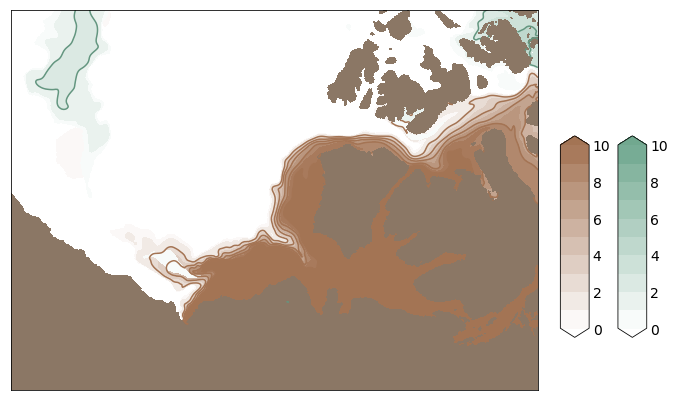

In [24]:
plot_monthly_mackenzie(2003,7)

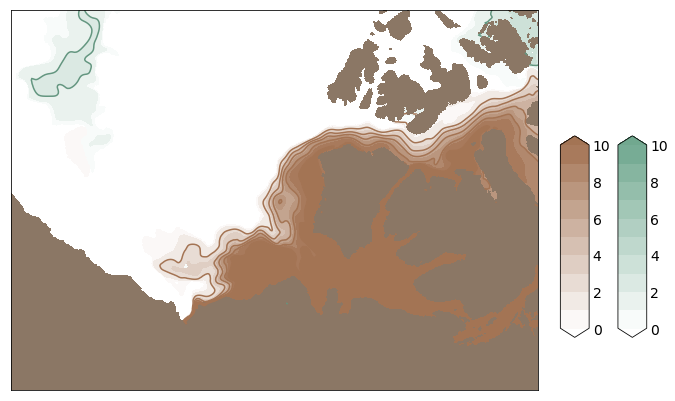

In [25]:
plot_monthly_mackenzie(2003,8)

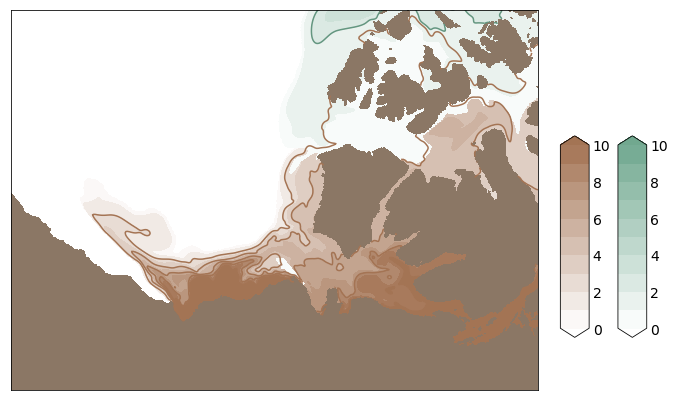

In [26]:
plot_monthly_mackenzie(2014,7)

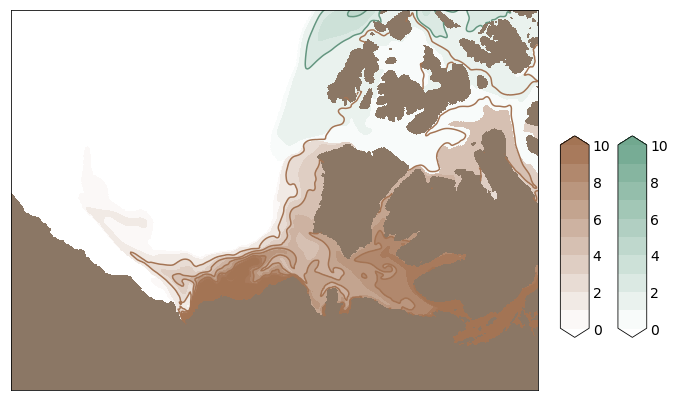

In [27]:
plot_monthly_mackenzie(2014,8)

# Mackenzie river analysis

Fichot et al. (2013): "A progressive switch from eastward to northwestward routing occurred between 2002 and 2011  and coincides with the rapid freshening of the Canada Basin." 

In [14]:
def load_5d_results(file_ref, file_cont):    
    base = nc.Dataset(file_ref)
    cont = nc.Dataset(file_cont)
    
    dmn_base = np.array(base.variables['dissolmn'])[0,:,:,:]
    dmn_cont = np.array(cont.variables['dissolmn'])[0,:,:,:]
    
    return dmn_base, dmn_cont

In [15]:
def plot_5d_mackenzie(ax, fday, time):

    proj2 = Basemap(projection='stere',lat_0 = 71, lon_0 = -135, resolution='i', width=1.5e6, height=1.0e6, ax=ax)
    
    x_land, y_land = proj2(lon, lat)
    proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
                   cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

    #---------------------
    x_model, y_model = proj2(lons, lats)

    # Coloured contours:
#     vmin_cont = 0; vmax_cont = 10; step_cont = 1;
#     CS2 = proj2.contourf(x_model, y_model, fday*100, \
#                          levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
#                          vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap, extend='both')
    CS2 = proj2.contourf(x_model, y_model, fday, 20, vmin=0, vmax=0.2, extend='both')#, \
#                          levels=np.arange(vmin_cont, vmax_cont+step_cont, step_cont), \
#                          vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap, extend='both')

#     # Contour lines:
#     contour_cont = 2; cvmax_cont = 10;
#     proj2.contour(x_model, y_model, fday*100, \
#                   levels=np.arange(vmin_cont, cvmax_cont+contour_cont, contour_cont), \
#                   vmin=vmin_cont, vmax=vmax_cont, colors='#a47454')
    
    ax.set_title(files_ref[time][93:110])

    return

Look at it on a shorter time scale in 2008, like in Fig. 3 of the paper:
- June 1-8
- June 9-16
- June 17-24
- June 25-July 2
- July 3-10
- July 11-18
- July 19-26
- July 27-August 3rd


Compare with wind patterns

In [16]:
#start_date and end_date are datetime objects
start_date = dt.datetime(2008,6,1)
end_date   = dt.datetime(2008,8,4)

In [17]:
files_list_ref  = np.sort(glob.glob('/data/brogalla/run_storage/Mn-set4-202004/ref-2008/'+\
                                    'ANHA12_EXH006_5d_20080101_20081231_ptrc_T_*'))
files_list_cont = np.sort(glob.glob('/data/brogalla/run_storage/riv-2b-202005/riv-2b-2008/'+\
                                    'ANHA12_EXH006_5d_20080101_20081231_ptrc_T_*'))

In [18]:
files_ref_start = [dt.datetime.strptime(i[93:101], "%Y%m%d") for i in files_list_ref]
files_ref_end   = [dt.datetime.strptime(i[102:110], "%Y%m%d") for i in files_list_ref]
files_ref       = list(compress(files_list_ref, [V > start_date and V < end_date for V in files_ref_start]))

files_cont_start = [dt.datetime.strptime(i[95:103], "%Y%m%d") for i in files_list_cont]
files_cont_end   = [dt.datetime.strptime(i[104:112], "%Y%m%d") for i in files_list_cont]
files_cont       = list(compress(files_list_cont, [V > start_date and V < end_date for V in files_cont_start]))

In [111]:
continental_contribution=np.empty((len(files_ref),isize,jsize))

for i in range(0,len(files_ref)):
    base, cont = load_5d_results(files_ref[i], files_cont[i])
    continental_contribution[i,:,:] = np.nanmean(np.divide(cont - base, base)[0:10,:,:], axis=0)
    
# Mask small values:
# ma_cont = np.ma.masked_where((continental_contribution < 0.006), continental_contribution)

In [79]:
def load_wind_results(year, Mackenzie=False):
    folder = '/data/brogalla/ANHA12/atmospheric_forcing/'
    fileu  = 'u10_gdps_y'+str(year)+'.nc'
    filev  = 'v10_gdps_y'+str(year)+'.nc'
    
    uyear  = nc.Dataset(folder+fileu)
    vyear  = nc.Dataset(folder+filev)
    
    u_wind = np.array(uyear.variables['u_wind'])
    v_wind = np.array(vyear.variables['v_wind'])
    lons = np.array(uyear.variables['LON'])
    lons = [lon-360 if (lon > 180) else lon for lon in lons] 
    lats = np.array(uyear.variables['LAT'])
    
    if Mackenzie:
        # find subset indices for the Mackenzie river:
        i=0; n=0;
        for lat in lats:
            if (lat > 70) & (i==0):
                min_lat = n
                i+=1
            elif (lat < 78) & (i==1):
                max_lat = n
            n+=1

        i=0; n=0;
        for lon in lons:
            if (lon < -160) & (lon > -161) & (i==0):
                min_lon = n
                i+=1
            elif (lon < -100) & (lon > -101) & (i==1):
                max_lon = n
            n+=1    

        wind_lons = lons[min_lon:max_lon]
        wind_lats = lats[min_lat:max_lat]

        uwind = u_wind[:,min_lat:max_lat,min_lon:max_lon]
        vwind = v_wind[:,min_lat:max_lat,min_lon:max_lon]
        return uwind, vwind, wind_lons, wind_lats
    else:
        return u_wind, v_wind, lons, lats

In [80]:
uwind, vwind, wind_lons, wind_lats = load_wind_results(2008, Mackenzie=True)

In [112]:
hourly_dates = [dt.datetime(2008,1,1)+dt.timedelta(hours=i) for i in range(1,365*24+1)]

# index of start date and end date within the hourly dates of the wind data:
start_hindex = (start_date - dt.datetime(2008,1,1)).days*24
end_hindex   = (end_date - dt.datetime(2008,1,1)).days*24

# dates during which I look at tracer concentrations as well:
overlap_dates = hourly_dates[start_hindex:end_hindex]
overlap_uwind = uwind[start_hindex:end_hindex,:,:]
overlap_vwind = vwind[start_hindex:end_hindex,:,:]

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(18,10))

time=0
for column in [0,1,2]:
    for axis in ax[column,:]:
        plot_5d_mackenzie(axis, continental_contribution[time,:,:], time)
        
        time+=1